#### Importing Dataset

In [1]:
import numpy as np
import pandas as pd

from preprocessing import ImputeMean
from preprocessing import TrainTestSplit
from preprocessing import ZeroSales


calendar_df = pd.read_csv('E:/Documents/TanXor/Dataset/calendar.csv')
sales_df = pd.read_csv('E:/Documents/TanXor/Dataset/sales_train_validation.csv')

#### Data Transformation

In [2]:
sales_df['d_id'] = sales_df['store_id'] + '_' + sales_df['dept_id']

sales_df = sales_df.drop(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1)

sales_df = sales_df.groupby('d_id').sum()

sales_df = sales_df.T

sales_df['d'] = sales_df.index

df = sales_df.merge(calendar_df, how = 'outer')

df = df.drop(['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'], axis=1)

df['date']=pd.to_datetime(df['date'])

df.set_index('date',inplace=True)

df = df.dropna()

In [5]:
neg_sales = ZeroSales.zero_sales(data)
imputer = ImputeMean.imputer(data, 0)
train_data, test_data = TrainTestSplit.data_split(data, 0.2)

### Visualizing the Data

<AxesSubplot:xlabel='date'>

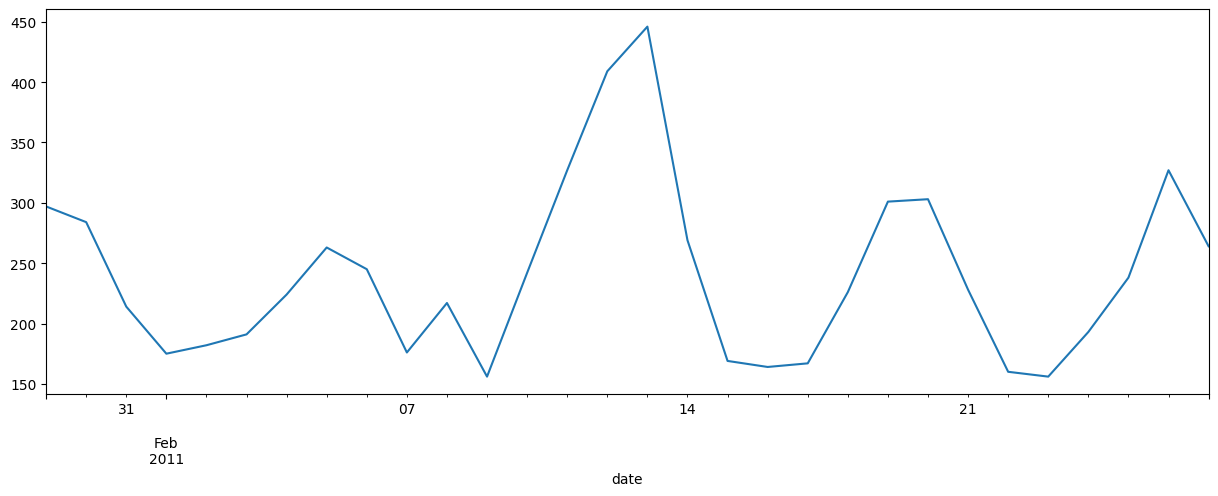

In [35]:
df_1 = df[['CA_1_FOODS_1']].copy()

df_1.rename(columns = {'CA_1_FOODS_1':'Sales'}, inplace = True)

df_1.index = df.index

In [7]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [10]:
def adfuller_test(sales):
    result=adfuller(sales)
    return result[1]

In [20]:
for i in df.columns:
    if (adfuller_test(df['Log']) <= 0.05):
        print(i, "Pass")
    else:
        print(i, "Fail")

LinAlgError: SVD did not converge

### Feature Engineering

In [14]:
def LagTransformation(data, column, lag):
    data['Lag'] = data[column].shift(lag)

In [36]:
def LogTransformation(data, column):
    data['Log_' + column] = data[column].apply(lambda x: np.log(x) if x > 0 else 0)

In [37]:
for i in df.columns:
    if (adfuller_test(df[i]) <= 0.05):
        print(i, "Pass")
    else:
        print(i, "Fail")
        LogTransformation(df, i)
        if (adfuller_test(df['Log_'+i]) <= 0.05):
            print(i, "Pass")
        else:
            print(i, "Failed Again")

CA_1_FOODS_1 Pass
CA_1_FOODS_2 Pass
CA_1_FOODS_3 Fail
CA_1_FOODS_3 Pass
CA_1_HOBBIES_1 Pass
CA_1_HOBBIES_2 Pass
CA_1_HOUSEHOLD_1 Fail
CA_1_HOUSEHOLD_1 Fail
CA_1_HOUSEHOLD_2 Fail
CA_1_HOUSEHOLD_2 Pass
CA_2_FOODS_1 Pass
CA_2_FOODS_2 Fail
CA_2_FOODS_2 Fail
CA_2_FOODS_3 Fail
CA_2_FOODS_3 Fail
CA_2_HOBBIES_1 Fail
CA_2_HOBBIES_1 Pass
CA_2_HOBBIES_2 Pass
CA_2_HOUSEHOLD_1 Fail
CA_2_HOUSEHOLD_1 Fail
CA_2_HOUSEHOLD_2 Fail
CA_2_HOUSEHOLD_2 Pass
CA_3_FOODS_1 Pass
CA_3_FOODS_2 Pass
CA_3_FOODS_3 Fail
CA_3_FOODS_3 Pass
CA_3_HOBBIES_1 Fail
CA_3_HOBBIES_1 Pass
CA_3_HOBBIES_2 Pass
CA_3_HOUSEHOLD_1 Fail
CA_3_HOUSEHOLD_1 Pass
CA_3_HOUSEHOLD_2 Pass
CA_4_FOODS_1 Pass
CA_4_FOODS_2 Fail
CA_4_FOODS_2 Pass
CA_4_FOODS_3 Fail
CA_4_FOODS_3 Pass
CA_4_HOBBIES_1 Fail
CA_4_HOBBIES_1 Pass
CA_4_HOBBIES_2 Pass
CA_4_HOUSEHOLD_1 Fail
CA_4_HOUSEHOLD_1 Fail
CA_4_HOUSEHOLD_2 Fail
CA_4_HOUSEHOLD_2 Fail
TX_1_FOODS_1 Pass
TX_1_FOODS_2 Pass
TX_1_FOODS_3 Pass
TX_1_HOBBIES_1 Fail
TX_1_HOBBIES_1 Pass
TX_1_HOBBIES_2 Pass
TX_1_HOUSEHO

MissingDataError: exog contains inf or nans

In [30]:
LogTransformation(df, df.columns[2])

In [35]:
print(adfuller_test(df[df.columns[-1]]))

LinAlgError: SVD did not converge

In [12]:
df_1['Sales_shifted'] = df_1['Sales'].shift(7)  # Shifting (Lag)

df_1['adj_log'] = np.log(df_1['Sales'])   # LogTransformation

df_1['Seasonal_Differnce'] = df_1['Sales'] - df_1['Sales_shifted']  # Differencing

adfuller_test(df_1['Seasonal_Differnce'].dropna())

NameError: name 'df_1' is not defined

### Model Training

In [40]:
model=sm.tsa.statespace.SARIMAX(df_1['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,7))
results=model.fit()

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [ ]:
df_1['forecast']=results.predict(start=1780,end=1913,dynamic=True)
df_1[['Sales','forecast']].iloc[1740:].plot()

### Hyperparamter Tuning

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Ignore ValueWarning from statsmodels
warnings.simplefilter('ignore', ValueWarning)

In [ ]:
### Import Packages ###
'''
import itertools

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = range(1, 6)
q = range(0, 6)
d = range(1, 2)
P = range(0, 4)
Q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, d, Q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, freq='D'):
    
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False, 
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=1000)
                predictions = output.predict(start=1800,end=1913,dynamic=True)

                test_data = ts.iloc[1800:1913]
                mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

                ans.append([comb, combs, output.bic, mape])
                print('SARIMAX {} x {}12 : MAPE Calculated ={}'.format(comb, combs, mape))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'mape'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['mape'],ascending=True)
    
    return ans_df
    
'''

In [ ]:
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
# best_params = sarimax_gridsearch(df_1['Sales'], pdq, pdqs, freq='D')

In [ ]:
# best_params.head(20)

In [ ]:
# Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(df_1['Sales'], 
                                    order=(3,1,3), 
                                    seasonal_order=(0,1,1,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
                                    
# Fit the model
output = sarimax.fit()
    
# Print output summary
print(output.summary())

# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));

In [ ]:
df_1['forecast']=output.predict(start=1800,end=1913,dynamic=True)
df_1[['Sales','forecast']].iloc[1800:].plot()

In [ ]:
%pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
#from sklearn import datasets

def objective(trial):
    p = trial.suggest_int('p', 0, 6)
    # d = trial.suggest_int('d', 1, 3)
    q = trial.suggest_int('q', 0, 6)
    P = trial.suggest_int('P', 0, 6)
    Q = trial.suggest_int('Q', 0, 6)
    # m = trial.suggest_int('m', 3, 8)
    srx = sm.tsa.statespace.SARIMAX(df_1['Sales'], 
                                    order=(p,1,q), 
                                    seasonal_order=(P,1,Q,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
    
    output = srx.fit(maxiter=1000)
    predictions = output.predict(start=1800,end=1913,dynamic=True)

    test_data = df_1['Sales'].iloc[1800:1913]
    mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

    return mape

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

In [ ]:
trial = study.best_trial
print('Mape: {}'.format(trial.value))

In [ ]:
print("Best hyperparameters: {}".format(trial.params))